In [221]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [222]:
# if mode=='build' will rebuild music note and duration lib
mode = 'build' #

# log file name - saves ["output", "store", "viz", "weights"]
zip_filename = "log3.zip" # log after note/duration build
zip_filename2 = "logf3.zip" # log after all is done

out_name = 'new_out3.wav'

In [223]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
print("GPU available:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.15.0
GPU available: []


In [224]:
try:
    import music21
except:
    !pip install music21
    !sudo apt-get update
    !sudo apt install musescore3 -y

try:
    import midi2audio
except:
    !pip install midi2audio
    !sudo apt-get update
    !sudo apt-get install fluidsynth -y
try:
    import MuseScore
except:
    !pip install MuseScore

In [225]:
!pip install mscore

In [226]:
!pip install np_utils

In [227]:
import mscore
print(dir(mscore))

['__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__']


In [228]:
import IPython
from IPython.display import Image, Audio
from midi2audio import FluidSynth
from music21 import corpus, converter, instrument, note, stream, chord, duration
import matplotlib.pyplot as plt
import time

import os
import pickle
import keras
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.utils import plot_model #from keras.utils.vis_utils import plot_model

import os
import numpy as np
import glob

from keras.layers import LSTM, Input, Dropout, Dense, Activation, Embedding, Concatenate, Reshape
from keras.layers import Flatten, RepeatVector, Permute, TimeDistributed
from keras.layers import Multiply, Lambda, Softmax
import keras.backend as K
from keras.models import Model
from tensorflow.keras.optimizers import RMSprop

#from keras.utils import np_utils
import np_utils
from keras.utils import to_categorical
import seaborn as sns

---
Orignal music

In [229]:
# PATH FOR DATA: '/content/drive/MyDrive/ME539 - Music Generation/data' maestro-v3.0.0-midi/maestro-v3.0.0/2018/MIDI-Unprocessed_Schubert10-12_MID--AUDIO_20_R2_2018_wav
datadir = '/content/drive/MyDrive/cs 539/input/input/classical-music-midi'

if False:
  from music21 import *
  us = environment.UserSettings()
  #us.create()
  #us.set('autoDownload', 'allow')
  us['autoDownload'] = 'allow'
  for key in sorted(us.keys()):
    print(key)
  datadir = '/content/drive/MyDrive/cs 539/input/input/classical-music-midi'


dataset_name = datadir+'/bach'
filename = 'bach_846'
file = "{}/{}.mid".format(dataset_name, filename)


original_score = converter.parse(file).chordify()

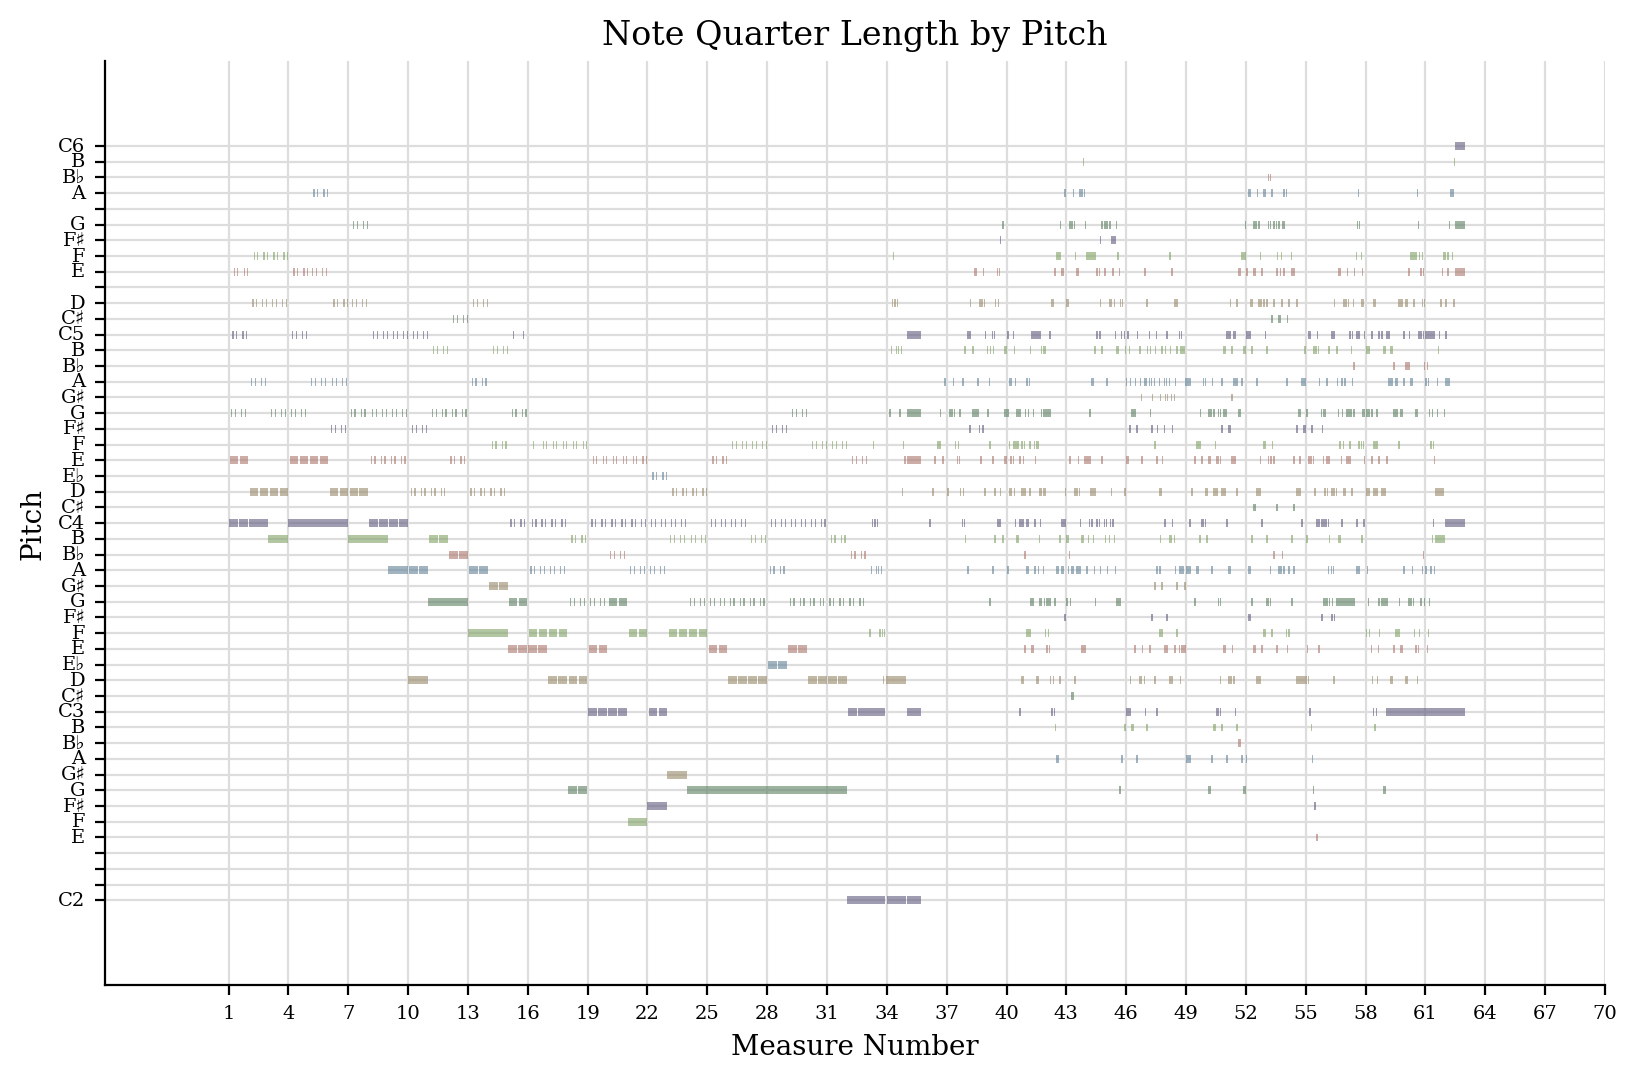

In [230]:
original_score.plot()

In [231]:
fs = FluidSynth(sample_rate=44100)
fname = datadir + '/bach/bach_846.mid'
file = fname
fs.midi_to_audio(file, 'bach_846.wav')
IPython.display.Audio('bach_846.wav', rate = 44100)

if False:
  fname = datadir + '/bach/bach_847.mid'
  file = fname
  fs.midi_to_audio(file, 'bach_847.wav')
  IPython.display.Audio('bach_847.wav', rate = 44100)

In [232]:
from music21 import scale, musicxml
#original_score.show()
GEX = musicxml.m21ToXml.GeneralObjectExporter()
print(dir(GEX))
m = GEX.fromGeneralObject(original_score)
m
m.show(fmt = 'midi')

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'classMapping', 'fromDiatonicScale', 'fromDuration', 'fromDynamic', 'fromGeneralNote', 'fromGeneralObject', 'fromMeasure', 'fromMusic21Object', 'fromPart', 'fromPitch', 'fromScale', 'fromScore', 'fromStream', 'fromVoice', 'generalObj', 'makeNotation', 'parse', 'parseWellformedObject']


In [233]:
from music21 import scale, musicxml


cMaj = scale.MajorScale('C')
print(type(cMaj), 'as')
GEX = musicxml.m21ToXml.GeneralObjectExporter()
m = GEX.fromDiatonicScale(cMaj)
m
m.show(fmt = 'midi')

<class 'music21.scale.MajorScale'> as


---
Extract Data

In [234]:
notes = []
durations = []

for element in original_score.flat:
    if isinstance(element, chord.Chord):
        notes.append('.'.join(n.nameWithOctave for n in element.pitches))
        durations.append(element.duration.quarterLength)

    if isinstance(element, note.Note):
        if element.isRest:
            notes.append(str(element.name))
            durations.append(element.duration.quarterLength)
        else:
            notes.append(str(element.nameWithOctave))
            durations.append(element.duration.quarterLength)

/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3553: Music21DeprecationWarning: .flat is deprecated.  Call .flatten() instead
  exec(code_obj, self.user_global_ns, self.user_ns)


In [235]:
print('\nduration', 'pitch')
idx = 0
for n,d in zip(notes,durations):
    if idx < 50:
        print(d, '\t', n)
    idx = idx + 1


duration pitch
0.25 	 C4
0.25 	 C4.E4
0.25 	 C4.E4.G4
0.25 	 C4.E4.C5
0.25 	 C4.E4.E5
0.25 	 C4.E4.G4
0.25 	 C4.E4.C5
0.25 	 C4.E4.E5
0.25 	 C4
0.25 	 C4.E4
0.25 	 C4.E4.G4
0.25 	 C4.E4.C5
0.25 	 C4.E4.E5
0.25 	 C4.E4.G4
0.25 	 C4.E4.C5
0.25 	 C4.E4.E5
0.25 	 C4
0.25 	 C4.D4
0.25 	 C4.D4.A4
0.25 	 C4.D4.D5
0.25 	 C4.D4.F5
0.25 	 C4.D4.A4
0.25 	 C4.D4.D5
0.25 	 C4.D4.F5
0.25 	 C4
0.25 	 C4.D4
0.25 	 C4.D4.A4
0.25 	 C4.D4.D5
0.25 	 C4.D4.F5
0.25 	 C4.D4.A4
0.25 	 C4.D4.D5
0.25 	 C4.D4.F5
0.25 	 B3
0.25 	 B3.D4
0.25 	 B3.D4.G4
0.25 	 B3.D4.D5
0.25 	 B3.D4.F5
0.25 	 B3.D4.G4
0.25 	 B3.D4.D5
0.25 	 B3.D4.F5
0.25 	 B3
0.25 	 B3.D4
0.25 	 B3.D4.G4
0.25 	 B3.D4.D5
0.25 	 B3.D4.F5
0.25 	 B3.D4.G4
0.25 	 B3.D4.D5
0.25 	 B3.D4.F5
0.25 	 C4
0.25 	 C4.E4


---
Creating music

HELPER FUNCTIONS

In [236]:
def get_music_list(data_folder):
    file_list = glob.glob(os.path.join(data_folder, "*.mid"))
    parser = converter
    return file_list, parser

def create_network(n_notes, n_durations, embed_size = 100, rnn_units = 256, use_attention = False):
    notes_in = Input(shape = (None,))
    durations_in = Input(shape = (None,))

    x1 = Embedding(n_notes, embed_size)(notes_in)
    x2 = Embedding(n_durations, embed_size)(durations_in)
    x = Concatenate()([x1,x2])
    x = LSTM(rnn_units, return_sequences=True)(x)

    if use_attention:
        x = LSTM(rnn_units, return_sequences=True)(x)
        e = Dense(1, activation='tanh')(x)
        e = Dense(1, activation='tanh')(e)
        e = Reshape([-1])(e)
        alpha = Activation('softmax')(e)
        alpha_repeated = Permute([2, 1])(RepeatVector(rnn_units)(alpha))
        c = Multiply()([x, alpha_repeated])
        c = Lambda(lambda xin: K.sum(xin, axis=1), output_shape=(rnn_units,))(c)
    else:
        c = LSTM(rnn_units)(x)

    notes_out = Dense(n_notes, activation = 'softmax', name = 'pitch')(c)
    durations_out = Dense(n_durations, activation = 'softmax', name = 'duration')(c)

    model = Model([notes_in, durations_in], [notes_out, durations_out])

    if use_attention:
        att_model = Model([notes_in, durations_in], alpha)
    else:
        att_model = None

    opti = RMSprop(learning_rate = 0.001)
    model.compile(loss=['categorical_crossentropy', 'categorical_crossentropy'], optimizer=opti)

    return model, att_model


def get_distinct(elements):
    # Get all pitch names
    element_names = sorted(set(elements))
    n_elements = len(element_names)
    return (element_names, n_elements)

def create_lookups(element_names):
    # create dictionary to map notes and durations to integers
    element_to_int = dict((element, number) for number, element in enumerate(element_names))
    int_to_element = dict((number, element) for number, element in enumerate(element_names))
    return (element_to_int, int_to_element)

def prepare_sequences(notes, durations, lookups, distincts, seq_len =32):
    note_to_int, int_to_note, duration_to_int, int_to_duration = lookups
    note_names, n_notes, duration_names, n_durations = distincts

    notes_network_input = []
    notes_network_output = []
    durations_network_input = []
    durations_network_output = []

    # create input sequences and the corresponding outputs
    for i in range(len(notes) - seq_len):
        notes_sequence_in = notes[i:i + seq_len]
        notes_sequence_out = notes[i + seq_len]
        notes_network_input.append([note_to_int[char] for char in notes_sequence_in])
        notes_network_output.append(note_to_int[notes_sequence_out])

        durations_sequence_in = durations[i:i + seq_len]
        durations_sequence_out = durations[i + seq_len]
        durations_network_input.append([duration_to_int[char] for char in durations_sequence_in])
        durations_network_output.append(duration_to_int[durations_sequence_out])

    n_patterns = len(notes_network_input)

    # reshape the input into a format compatible with LSTM layers
    notes_network_input = np.reshape(notes_network_input, (n_patterns, seq_len))
    durations_network_input = np.reshape(durations_network_input, (n_patterns, seq_len))
    network_input = [notes_network_input, durations_network_input]

    notes_network_output = to_categorical(notes_network_output, num_classes=n_notes)
    durations_network_output = to_categorical(durations_network_output, num_classes=n_durations)
    network_output = [notes_network_output, durations_network_output]
    return (network_input, network_output)

def sample_with_temp(preds, temperature):
    if temperature == 0:
        return np.argmax(preds)
    else:
        preds = np.log(preds) / temperature
        exp_preds = np.exp(preds)
        preds = exp_preds / np.sum(exp_preds)
        return np.random.choice(len(preds), p=preds)

RUN PARAMS

In [237]:
import os

def list_folders_with_directories(directory):
    folders_with_directories = []
    for folder in os.listdir(directory):
        folder_path = os.path.join(directory, folder)
        if os.path.isdir(folder_path):
            folders_with_directories.append(folder_path)
    return folders_with_directories

# Replace 'path_to_your_directory' with the path to your directory
directory = datadir
folders_with_directories = list_folders_with_directories(directory)
print("Folders with directories in", directory, ":", folders_with_directories)

Folders with directories in /content/drive/MyDrive/cs 539/input/input/classical-music-midi : ['/content/drive/MyDrive/cs 539/input/input/classical-music-midi/granados', '/content/drive/MyDrive/cs 539/input/input/classical-music-midi/chopin', '/content/drive/MyDrive/cs 539/input/input/classical-music-midi/debussy', '/content/drive/MyDrive/cs 539/input/input/classical-music-midi/balakir', '/content/drive/MyDrive/cs 539/input/input/classical-music-midi/brahms', '/content/drive/MyDrive/cs 539/input/input/classical-music-midi/albeniz', '/content/drive/MyDrive/cs 539/input/input/classical-music-midi/bach', '/content/drive/MyDrive/cs 539/input/input/classical-music-midi/beeth', '/content/drive/MyDrive/cs 539/input/input/classical-music-midi/borodin', '/content/drive/MyDrive/cs 539/input/input/classical-music-midi/burgm', '/content/drive/MyDrive/cs 539/input/input/classical-music-midi/schubert', '/content/drive/MyDrive/cs 539/input/input/classical-music-midi/schumann', '/content/drive/MyDrive/

In [238]:
# run params
run_folder = ''

store_folder = os.path.join(run_folder, 'store')
data_folder = datadir + '/liszt'

if not os.path.exists('store'):
    os.mkdir(os.path.join(run_folder, 'store'))
    os.mkdir(os.path.join(run_folder, 'output'))
    os.mkdir(os.path.join(run_folder, 'weights'))
    os.mkdir(os.path.join(run_folder, 'viz'))

# data params
intervals = range(1)
seq_len = 32

# model params
embed_size = 100
rnn_units = 256
use_attention = True

In [239]:
import time

music_listX, parser = get_music_list(data_folder) # used to obtain parser

import random
random_numbers = [random.randint(1, 10) for _ in range(7)]



if mode == 'build':
    music_list, parser = get_music_list(data_folder)
    #music_list = []
    #for fldrs in [folders_with_directories[i] for i in random_numbers]:
     # print(fldrs)
      #mlist, parser = (get_music_list(fldrs))
      #music_list.extend(mlist)
    print(len(music_list), 'files in total')
    print(music_list)

    notes = []
    durations = []

    for i, file in enumerate(music_list[:7]):
        start_time = time.time()

        print(i+1, "Parsing %s" % file)
        print(file)
        original_score = parser.parse(file).chordify()
        for interval in intervals:
            score = original_score.transpose(interval)

            notes.extend(['START'] * seq_len)
            durations.extend([0]* seq_len)

            for element in score.flat:
                if isinstance(element, note.Note):
                    if element.isRest:
                        notes.append(str(element.name))
                        durations.append(element.duration.quarterLength)
                    else:
                        notes.append(str(element.nameWithOctave))
                        durations.append(element.duration.quarterLength)

                if isinstance(element, chord.Chord):
                    notes.append('.'.join(n.nameWithOctave for n in element.pitches))
                    durations.append(element.duration.quarterLength)

        end_time = time.time()
        elapsed_time = end_time - start_time
        print("Elapsed time:", elapsed_time, "seconds")


    with open(os.path.join(store_folder, 'notes'), 'wb') as f:
        pickle.dump(notes, f)
    with open(os.path.join(store_folder, 'durations'), 'wb') as f:
        pickle.dump(durations, f)
else:
    with open(os.path.join(store_folder, 'notes'), 'rb') as f:
        notes = pickle.load(f)
    with open(os.path.join(store_folder, 'durations'), 'rb') as f:
        durations = pickle.load(f)

16 files in total
['/content/drive/MyDrive/cs 539/input/input/classical-music-midi/liszt/liz_rhap02.mid', '/content/drive/MyDrive/cs 539/input/input/classical-music-midi/liszt/liz_et6.mid', '/content/drive/MyDrive/cs 539/input/input/classical-music-midi/liszt/liz_et_trans4.mid', '/content/drive/MyDrive/cs 539/input/input/classical-music-midi/liszt/liz_et_trans5.mid', '/content/drive/MyDrive/cs 539/input/input/classical-music-midi/liszt/liz_rhap12.mid', '/content/drive/MyDrive/cs 539/input/input/classical-music-midi/liszt/liz_et_trans8.mid', '/content/drive/MyDrive/cs 539/input/input/classical-music-midi/liszt/liz_liebestraum.mid', '/content/drive/MyDrive/cs 539/input/input/classical-music-midi/liszt/liz_et3.mid', '/content/drive/MyDrive/cs 539/input/input/classical-music-midi/liszt/liz_et2.mid', '/content/drive/MyDrive/cs 539/input/input/classical-music-midi/liszt/liz_rhap09.mid', '/content/drive/MyDrive/cs 539/input/input/classical-music-midi/liszt/liz_donjuan.mid', '/content/drive/My

In [240]:
print(parser)

<module 'music21.converter' from '/usr/local/lib/python3.10/dist-packages/music21/converter/__init__.py'>


---
EMBEDDING NOTE AND DURATION

In [241]:
# get the distinct sets of notes and durations
note_names, n_notes = get_distinct(notes)
duration_names, n_durations = get_distinct(durations)
distincts = [note_names, n_notes, duration_names, n_durations]

with open(os.path.join(store_folder, 'distincts'), 'wb') as f:
    pickle.dump(distincts, f)

# make the lookup dictionaries for notes and dictionaries and save
note_to_int, int_to_note = create_lookups(note_names)
duration_to_int, int_to_duration = create_lookups(duration_names)
lookups = [note_to_int, int_to_note, duration_to_int, int_to_duration]

with open(os.path.join(store_folder, 'lookups'), 'wb') as f:
    pickle.dump(lookups, f)

In [242]:
print('\nnote_to_int')
for i, item in enumerate(note_to_int.items()):
    if i < 10:
        print(item)


note_to_int
('A1', 0)
('A1.A2', 1)
('A1.A2.A3', 2)
('A1.A2.A3.A4', 3)
('A1.A2.A3.A4.C5.E5', 4)
('A1.A2.A3.B3', 5)
('A1.A2.A3.B3.C4.D4.E-4.A4', 6)
('A1.A2.A3.C#4.E4.A4.A5.C#6.E6.A6', 7)
('A1.A2.A3.C4.C#4.E-4.E4.A4', 8)
('A1.A2.A3.C4.E4', 9)


In [243]:
print('\nduration_to_int')
duration_to_int


duration_to_int


{0: 0,
 Fraction(1, 12): 1,
 Fraction(1, 6): 2,
 0.25: 3,
 Fraction(1, 3): 4,
 Fraction(5, 12): 5,
 0.5: 6,
 Fraction(7, 12): 7,
 Fraction(2, 3): 8,
 0.75: 9,
 Fraction(5, 6): 10,
 Fraction(11, 12): 11,
 1.0: 12,
 1.25: 13,
 1.5: 14,
 1.75: 15,
 2.0: 16,
 2.75: 17,
 3.0: 18,
 4.0: 19,
 5.25: 20}

In [244]:
network_input, network_output = prepare_sequences(notes, durations, lookups, distincts, seq_len)

In [245]:
print('pitch input')
print(network_input[0][100])
print(notes[100:132])
print('duration input')
print(network_input[1][100])
print(durations[100:132])
print('pitch target')
print(network_output[0][0])
print('duration target')
print(network_output[1][0])

pitch input
[1802 1706 1726 1727 1772 1760 1802 1898 1768 1726 1753 1802 1897 1768
 1742 1760 1253 1134 1136 1251 1250 1253 1242 1253 1180 1232 1231 1241
 1240 4181 4100 4163]
['C#2.C#4', 'C#2.A2.F#3.A3.E-4.E4', 'C#2.C#3', 'C#2.C#3.A3', 'C#2.C#3.E4', 'C#2.C#3.E-4', 'C#2.C#4', 'C#2.G#2.C#4.E-4', 'C#2.C#3.E3.G#3.C#4', 'C#2.C#3', 'C#2.C#3.C4', 'C#2.C#4', 'C#2.G#2.C#4', 'C#2.C#3.E3.G#3.C#4', 'C#2.C#3.C#4', 'C#2.C#3.E-4', 'B1.E4', 'B1', 'B1.B2', 'B1.E3.G#3.B3.E4', 'B1.E3.E4', 'B1.E4', 'B1.E-4', 'B1.E4', 'B1.B2.F#4', 'B1.E-3.A3.B3.G#4', 'B1.E-3.A3.B3.E-4.G#4', 'B1.E-3.G#4', 'B1.E-3.F#4', 'E2.E4', 'E2.B2.E4.F#4', 'E2.E3.G#3.B3.E4']
duration input
[3 3 3 3 3 3 9 3 6 3 3 9 3 6 3 3 3 6 3 6 6 3 3 3 3 3 3 3 3 9 3 6]
[0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.75, 0.25, 0.5, 0.25, 0.25, 0.75, 0.25, 0.5, 0.25, 0.25, 0.25, 0.5, 0.25, 0.5, 0.5, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.75, 0.25, 0.5]
pitch target
[0. 0. 0. ... 0. 0. 0.]
duration target
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

---
MODELING

In [246]:
model, att_model = create_network(n_notes, n_durations, embed_size, rnn_units, use_attention)
model.summary()

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_11 (InputLayer)       [(None, None)]               0         []                            
                                                                                                  
 input_12 (InputLayer)       [(None, None)]               0         []                            
                                                                                                  
 embedding_10 (Embedding)    (None, None, 100)            708100    ['input_11[0][0]']            
                                                                                                  
 embedding_11 (Embedding)    (None, None, 100)            2100      ['input_12[0][0]']            
                                                                                           

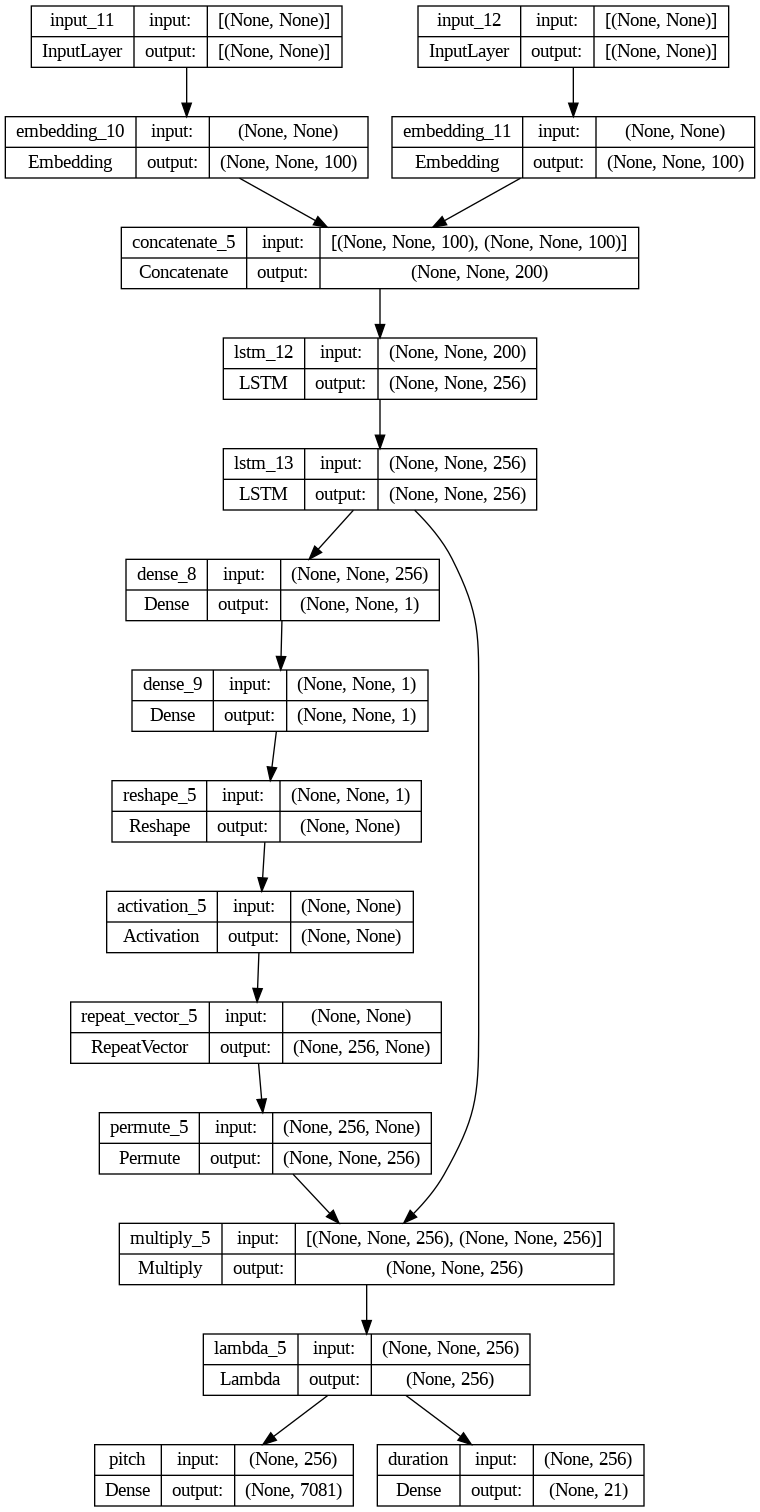

In [247]:
plot_model(model, to_file=os.path.join(run_folder ,'viz/model.png'), show_shapes = True, show_layer_names = True)

---
TRAINING

In [248]:
# This is used to save data, usually crashes here
import subprocess

folders = ["output", "store", "viz", "weights"] # folders to zip
command = ["zip", "-r", zip_filename] + folders #construct command
subprocess.run(command) #execute command

CompletedProcess(args=['zip', '-r', 'log3.zip', 'output', 'store', 'viz', 'weights'], returncode=0)

In [250]:
weights_folder = os.path.join(run_folder, 'weights_improve') # keep tracks of improvements - not saved
weights_folder2 = os.path.join(run_folder, 'weights') # keeps tracks of weight

checkpoint1 = ModelCheckpoint(
    os.path.join(weights_folder, "weights-improvement-{epoch:02d}-{loss:.4f}-bigger.h5"),
    monitor='loss',
    verbose=0,
    save_best_only=True,
    mode='min'
)

checkpoint2 = ModelCheckpoint(
    os.path.join(weights_folder, "weights.h5"),
    monitor='loss',
    verbose=0,
    save_best_only=True,
    mode='min'
)

early_stopping = EarlyStopping(
    monitor='loss'
    , restore_best_weights=True
    , patience = 10
)


callbacks_list = [
    checkpoint1
    , checkpoint2
    , early_stopping
 ]

model.save_weights(os.path.join(weights_folder2, "weights.h5"))
model.fit(network_input, network_output
          #, epochs=2000000, batch_size=32
          , epochs=20, batch_size=32
          , validation_split = 0.3
          , callbacks=callbacks_list
          , shuffle=True
         )

Epoch 1/20
349/349 [==============================] - ETA: 0s - loss: 8.9985 - pitch_loss: 7.9761 - duration_loss: 1.0223

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


349/349 [==============================] - 144s 413ms/step - loss: 8.9985 - pitch_loss: 7.9761 - duration_loss: 1.0223 - val_loss: 9.8461 - val_pitch_loss: 8.7892 - val_duration_loss: 1.0569
Epoch 2/20
349/349 [==============================] - 140s 402ms/step - loss: 8.7078 - pitch_loss: 7.7470 - duration_loss: 0.9609 - val_loss: 10.0856 - val_pitch_loss: 8.8371 - val_duration_loss: 1.2485
Epoch 3/20
349/349 [==============================] - 143s 410ms/step - loss: 8.4942 - pitch_loss: 7.5670 - duration_loss: 0.9272 - val_loss: 10.0639 - val_pitch_loss: 8.8583 - val_duration_loss: 1.2056
Epoch 4/20
349/349 [==============================] - 145s 415ms/step - loss: 8.3112 - pitch_loss: 7.4092 - duration_loss: 0.9020 - val_loss: 10.2108 - val_pitch_loss: 8.8832 - val_duration_loss: 1.3276
Epoch 5/20
349/349 [==============================] - 147s 422ms/step - loss: 8.1372 - pitch_loss: 7.2601 - duration_loss: 0.8770 - val_loss: 10.2064 - val_pitch_loss: 8.8767 - val_duration_loss: 1.32

In [251]:
model.load_weights(os.path.join(weights_folder, "weights.h5"))


---
PREDICTING

In [252]:
# prediction params
notes_temp=0.5
duration_temp = 0.5
max_extra_notes = 50
max_seq_len = 32
seq_len = 32

notes = ['START']
durations = [0]

if seq_len is not None:
    notes = ['START'] * (seq_len - len(notes)) + notes
    durations = [0] * (seq_len - len(durations)) + durations

sequence_length = len(notes)

In [253]:
prediction_output = []
notes_input_sequence = []
durations_input_sequence = []
overall_preds = []

for n, d in zip(notes,durations):
    note_int = note_to_int[n]
    duration_int = duration_to_int[d]

    notes_input_sequence.append(note_int)
    durations_input_sequence.append(duration_int)

    prediction_output.append([n, d])

    if n != 'START':
        midi_note = note.Note(n)
        new_note = np.zeros(128)
        new_note[midi_note.pitch.midi] = 1
        overall_preds.append(new_note)

att_matrix = np.zeros(shape = (max_extra_notes+sequence_length, max_extra_notes))

for note_index in range(max_extra_notes):

    prediction_input = [
        np.array([notes_input_sequence])
        , np.array([durations_input_sequence])
       ]

    notes_prediction, durations_prediction = model.predict(prediction_input, verbose=0)
    if use_attention:
        att_prediction = att_model.predict(prediction_input, verbose=0)[0]
        att_matrix[(note_index-len(att_prediction)+sequence_length):(note_index+sequence_length), note_index] = att_prediction

    new_note = np.zeros(128)

    for idx, n_i in enumerate(notes_prediction[0]):
        try:
            note_name = int_to_note[idx]
            midi_note = note.Note(note_name)
            new_note[midi_note.pitch.midi] = n_i
        except:
            pass

    overall_preds.append(new_note)

    i1 = sample_with_temp(notes_prediction[0], notes_temp)
    i2 = sample_with_temp(durations_prediction[0], duration_temp)

    note_result = int_to_note[i1]
    duration_result = int_to_duration[i2]

    prediction_output.append([note_result, duration_result])

    notes_input_sequence.append(i1)
    durations_input_sequence.append(i2)

    if len(notes_input_sequence) > max_seq_len:
        notes_input_sequence = notes_input_sequence[1:]
        durations_input_sequence = durations_input_sequence[1:]

    if note_result == 'START':
        break

overall_preds = np.transpose(np.array(overall_preds))
print('Generated sequence of {} notes'.format(len(prediction_output)))

Generated sequence of 82 notes


INTERPRETING MODEL

HEATMAP

Text(0.5, 1.0, 'Probability distribution of the next possible note over time')

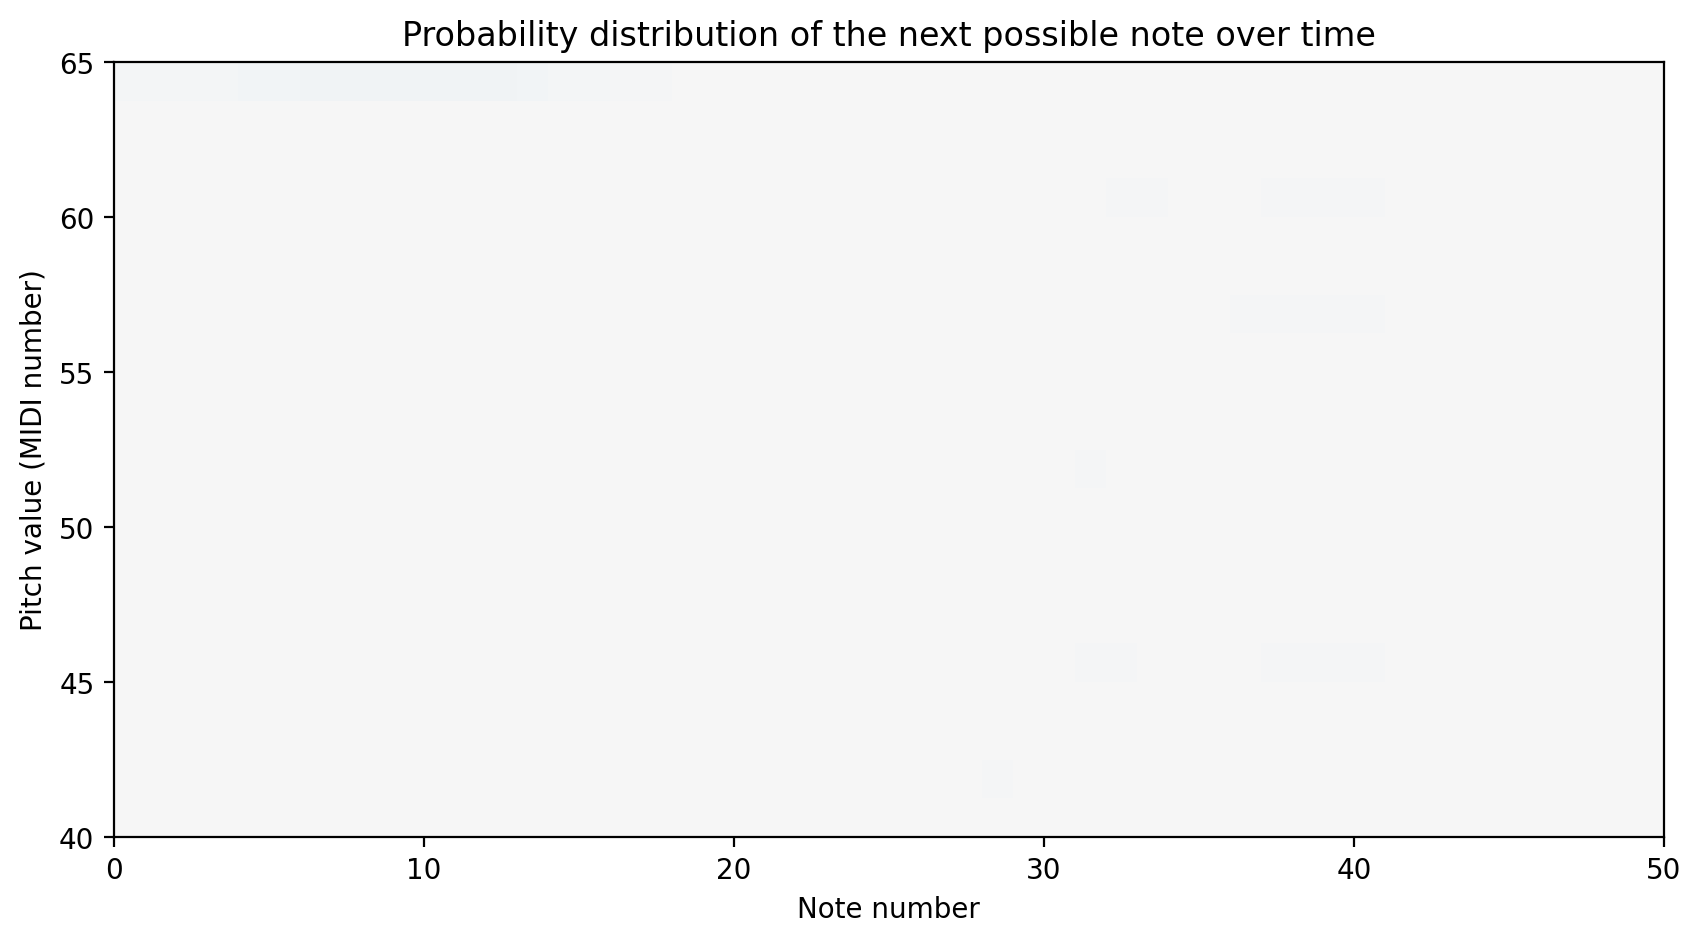

In [254]:
fig, ax = plt.subplots(figsize=(10,10))
ax.set_yticks([int(j) for j in range(40,66,5)])
plt.imshow(overall_preds[40:60,:], origin="lower", cmap='RdBu', vmin = -0.5, vmax = 0.5, extent=[0, max_extra_notes, 40,65])
plt.xlabel("Note number")
plt.ylabel("Pitch value (MIDI number)")
plt.title("Probability distribution of the next possible note over time")

In [255]:
output_folder = os.path.join(run_folder, 'output')

midi_stream = stream.Stream()

# create note and chord objects based on the values generated by the model
for pattern in prediction_output:
    note_pattern, duration_pattern = pattern
    # pattern is a chord
    if ('.' in note_pattern):
        notes_in_chord = note_pattern.split('.')
        chord_notes = []
        for current_note in notes_in_chord:
            new_note = note.Note(current_note)
            new_note.duration = duration.Duration(duration_pattern)
            new_note.storedInstrument = instrument.Violoncello()
            chord_notes.append(new_note)
        new_chord = chord.Chord(chord_notes)
        midi_stream.append(new_chord)
    elif note_pattern == 'rest':
    # pattern is a rest
        new_note = note.Rest()
        new_note.duration = duration.Duration(duration_pattern)
        new_note.storedInstrument = instrument.Violoncello()
        midi_stream.append(new_note)
    elif note_pattern != 'START':
    # pattern is a note
        new_note = note.Note(note_pattern)
        new_note.duration = duration.Duration(duration_pattern)
        new_note.storedInstrument = instrument.Violoncello()
        midi_stream.append(new_note)

midi_stream = midi_stream.chordify()
# midi_stream.show(fmt = 'midi')
timestr = time.strftime("%Y%m%d-%H%M%S")
new_file = 'output-' + timestr + '.mid'
midi_stream.write('midi', fp=os.path.join(output_folder, new_file))

'output/output-20240505-041948.mid'

In [256]:
new_path = 'output/'+new_file
fs = FluidSynth()
fs.midi_to_audio(new_path, out_name)

ATTENTION

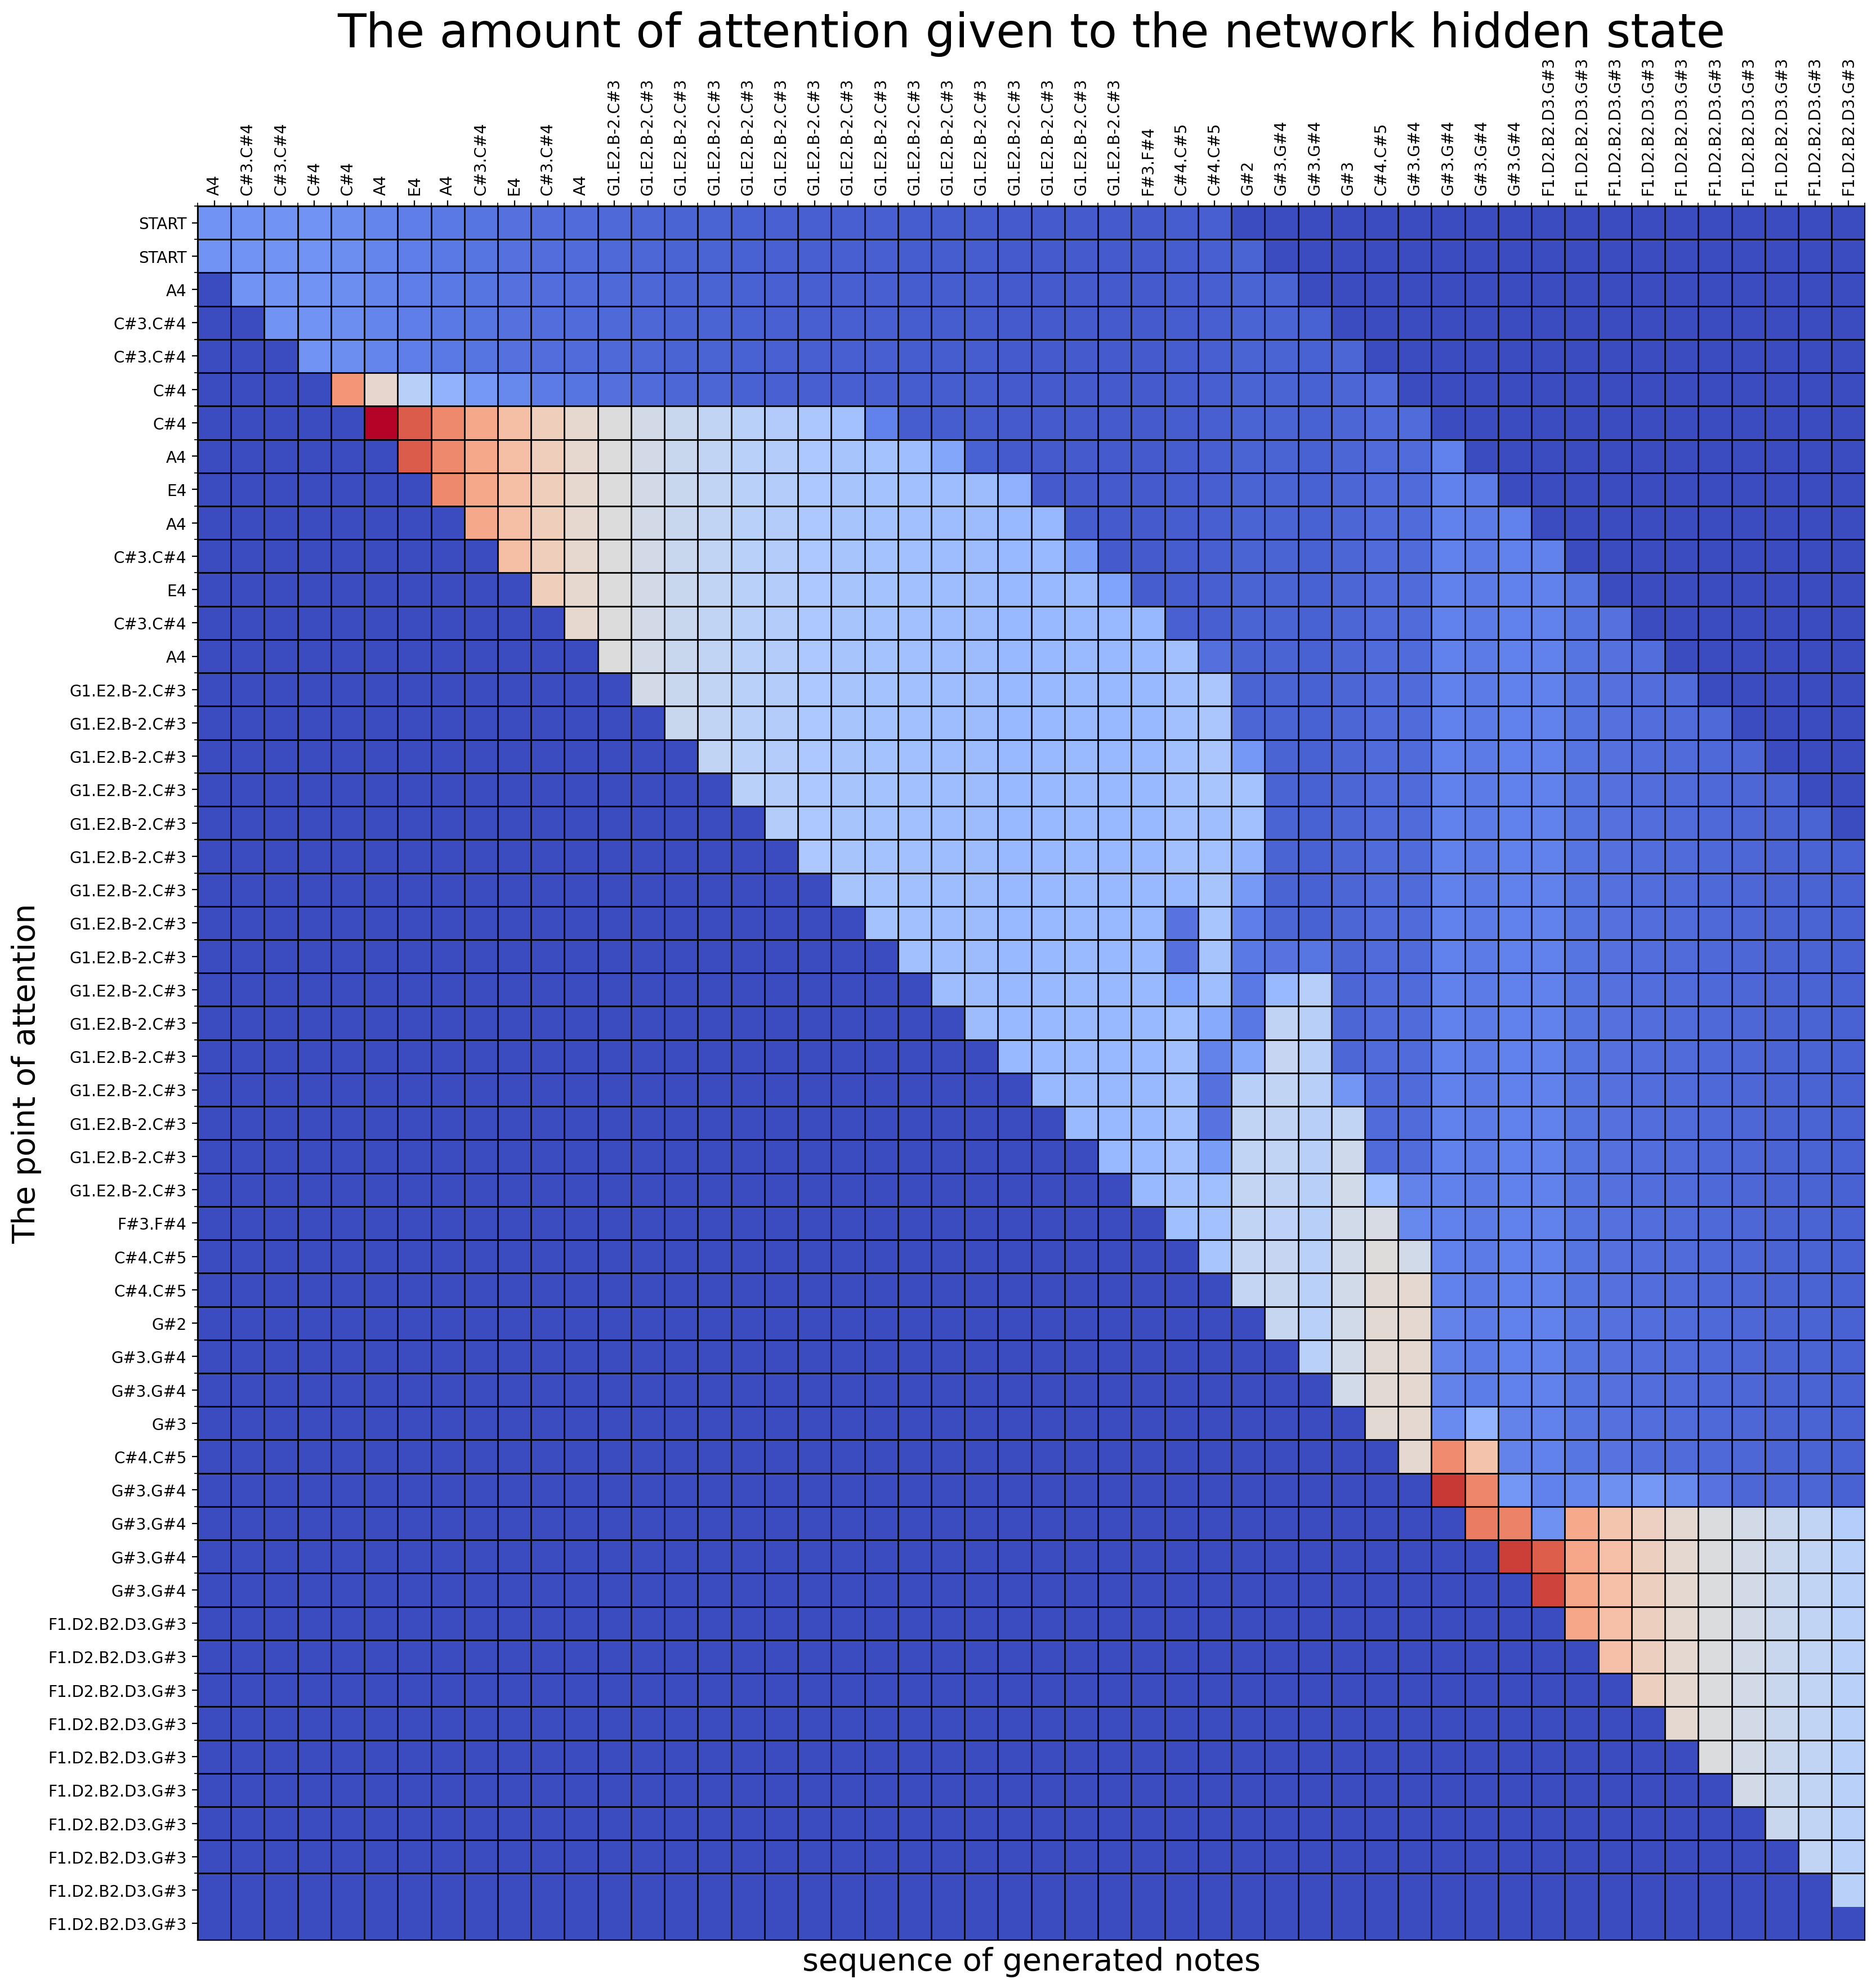

In [257]:
if use_attention:
    fig, ax = plt.subplots(figsize=(20,20))
    im = ax.imshow(att_matrix[(seq_len-2):,], cmap='coolwarm', interpolation='nearest')

    # Minor ticks
    ax.set_xticks(np.arange(-.5, len(prediction_output)- seq_len, 1), minor=True);
    ax.set_yticks(np.arange(-.5, len(prediction_output)- seq_len, 1), minor=True);

    # Gridlines based on minor ticks
    ax.grid(which='minor', color='black', linestyle='-', linewidth=1)

    # We want to show all ticks...
    ax.set_xticks(np.arange(len(prediction_output) - seq_len))
    ax.set_yticks(np.arange(len(prediction_output)- seq_len+2))
    # ... and label them with the respective list entries
    ax.set_xticklabels([n[0] for n in prediction_output[(seq_len):]])
    ax.set_yticklabels([n[0] for n in prediction_output[(seq_len - 2):]])
    ax.xaxis.tick_top()
    plt.setp(ax.get_xticklabels(), rotation=90, ha="left", va = "center", rotation_mode="anchor")
    plt.xlabel("sequence of generated notes",fontsize=20)
    plt.ylabel("The point of attention",fontsize=20)
    plt.title("The amount of attention given to the network hidden state",fontsize=30)
    plt.show()

---
MAKING NEW

In [258]:
new_score = converter.parse(new_path).chordify()

GEX = musicxml.m21ToXml.GeneralObjectExporter()
print(dir(GEX))
m = GEX.fromGeneralObject(new_score)
m
m.show(fmt = 'midi')

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'classMapping', 'fromDiatonicScale', 'fromDuration', 'fromDynamic', 'fromGeneralNote', 'fromGeneralObject', 'fromMeasure', 'fromMusic21Object', 'fromPart', 'fromPitch', 'fromScale', 'fromScore', 'fromStream', 'fromVoice', 'generalObj', 'makeNotation', 'parse', 'parseWellformedObject']


In [259]:
folders = ["output", "store", "viz", "weights"] # folders to zip
command = ["zip", "-r", zip_filename2] + folders #construct command
subprocess.run(command) #execute command

CompletedProcess(args=['zip', '-r', 'logf3.zip', 'output', 'store', 'viz', 'weights'], returncode=0)